In [1]:
using DrWatson
using IJulia

@quickactivate


# When we want to start working in a new computer
"""
using Pkg
Pkg.instantiate()
"""

using HDF5
using Printf
using LinearAlgebra
using Distributed
using CairoMakie
using Strided


  Activating project at `~/Desktop/Uni/PhD/hoping_chain_tensors`


In [2]:
using ITensors, ITensorMPS

"""
# RUN THIS IN THE REPL!!! this is for compiling an itensor image so when we start it does not take ages to 
# compile the pakages. This only needs to be run once per kernel/machine
#  or when you update the packages
# to create the sys_itensor.so image

using PackageCompiler

ITensors.compile()

# To load the image in a jupyter notebook:
# using IJulia
# installkernel("julia_ITensors","--sysimage=~/.julia/sysimages/sys_itensors.so")
# To load the image in vscode just add this to the julia.additionalArgs setting in Settings.json
# "--sysimage ~/.julia/sysimages/sys_itensors.so"
"""


"# RUN THIS IN THE REPL!!! this is for compiling an itensor image so when we start it does not take ages to \n# compile the pakages. This only needs to be run once per kernel/machine\n#  or when you update the packages\n# to create the sys_itensor.so image\n\nusing PackageComp" ⋯ 42 bytes ⋯ "age in a jupyter notebook:\n# using IJulia\n# installkernel(\"julia_ITensors\",\"--sysimage=~/.julia/sysimages/sys_itensors.so\")\n# To load the image in vscode just add this to the julia.additionalArgs setting in Settings.json\n# \"--sysimage ~/.julia/sysimages/sys_itensors.so\"\n"

In [3]:
Strided.disable_threads()
println(Strided.get_num_threads())
println(Threads.nthreads())

1
4


In [97]:
L = 22
J = 1.0 # qpc hopping
t = 0.1 # qubit hopping
Ω = 0.0 # interaction
spread = 2.0 # spread of the gaussian wavepacket
K0 = pi/3 # group velocity of wavepacket
X0 = 1 # initial position of the wavepacket
Bindex = round(Int64, L/2) # bond index
t_step = 0.1
ttotal = 17
qinit = "free" # "fixed"
evol_type = "TEBD" # TDVP

cutoff_exponent = -18 # -18 -20
cutoff = 10.0^cutoff_exponent

# creates the initial supperposition for the qubit
θ = pi/3
ϕ = 0
β0 = cos(0.5*θ) 
β1 = sin(0.5*θ)*exp(1im * ϕ)


0.49999999999999994 + 0.0im

# Functions

In [98]:
function build_tebd2_gates(Sites,J,t, Ω, B, Δτ)
    ChainL = length(Sites) - 2
    # build the gates for a single tebd2 step
    # Sites: MPS site object for fermionic sites
    # J,t, Ω, B, Δτ: Floats representing QPC hoppin, qubit hopping, Interaction
    # Bond index and time interval respectively
    gates = ITensor[]
    
    # create the QPC gates
    for j in 1:(ChainL-1)
        s1 = Sites[j]
        s2 = Sites[j+1] 
        h0 = -J*(op("cdag",s1)*op("c",s2) + op("cdag",s2)*op("c",s1) )
        # time evolution operator
        Gj = exp(-im * Δτ/2 * h0)
        push!(gates, Gj)
    end
    # create the qubit gate
    s1 = Sites[end-1]
    s2 = Sites[end]
    h0 = -t*(op("cdag",s1)*op("c",s2) + op("cdag",s2)*op("c",s1) )
    Gj = exp(-im * Δτ/2 * h0)
    push!(gates, Gj)
    
    # create the interaction gate
    s1 = Sites[end-1]
    s2 = Sites[B-1] 
    s3 = Sites[B] 
    hint = Ω*op("N",s1)*( op("cdag",s2)*op("c",s3) + op("cdag",s3)*op("c",s2) )
    Gj = exp(-im * Δτ/2 * hint)
    
    push!(gates, Gj)
    # reverse the order for the TEBD2 version
    append!(gates, reverse(gates))
    
    return gates
end

function entangement_S(ψ, b)
    # b: index where we do the bipartition
    psi = orthogonalize(ψ, b)
    # do the SVM
    U,S,V = svd(psi[b], (linkinds(psi, b-1)..., siteinds(psi, b)...))
    SvN = 0.0
    # Geth the schmidt coefficients
    for n=1:dim(S, 1)
        p = S[n,n]^2
        SvN -= p * log(p)
    end
    return SvN
end

function build_wave_packet(L, l0, k0, σ)
    x = 1:L
    # generates gaussian distribution coefficients for the QPC init
    coefs = @. exp(-0.5*(x-l0)^2/(σ^2) )*exp(1im*k0*(x-l0))
    return coefs/ norm(coefs)
end 

function create_composite_basis(Sites,L)
    # creates the bassis of the composiste QPCxqubit
    # create the computational basis for the QPCxQubit
    MPS_vectors = []
    Basis_vectors = []
    for i in 1:L
        # range is backward so we don't mess up the qubit order
        for j in 1:-1:0
            bvec = ["0" for n in 1:L+2]
            bvec[i] = "1"
            bvec[end-j] = "1"
            push!(Basis_vectors, bvec)
            push!(MPS_vectors, MPS(Sites, bvec))
        end
    end
    return MPS_vectors,Basis_vectors
end

function save_results(file_name, Param_dict, occupations_lin, bond_dimensions, 
                time_list, entropies, density_matrices)
    # saves the results in the form of an hdf5 file
    fid = h5open(datadir()*file_name, "w")
        # write the metadata to its own group
        create_group(fid, "metadata")
        meta = fid["metadata"]
        for (k, v) in Param_dict
                meta[k] = v  # save each entry under its key
        end
    
        # saves data
        res_g = create_group(fid, "results")
        res_g["occupations"] = occupations_lin
        res_g["bond_dimensions"] = bond_dimensions
        res_g["time_list"] = time_list
        res_g["entropies"] = entropies
        res_g["qubit_density_matrices"] = density_matrices
    
    close(fid)
    
end



function PartialTrace(W::MPO, l::Int, r::Int)
    # from https://itensor.discourse.group/t/how-to-ensure-partial-trace-of-an-mpo-returns-an-mpo/1931
    # Get the total number of sites
    N = length(W)
    
    # Validate input
    if l + r > N
        error("The sum l + r cannot be greater than the total number of sites N.")
    end

    # Determine the indices for the sites to keep
    keep_sites = l+1:N-r
    
    # Initialize the reduced density matrix (RDM)
    rdm = W[keep_sites[1]]
    L = R = ITensor(1.)
    
    # Contract the MPO tensors for the middle sites
    for j in 2:length(keep_sites)
        rdm *= W[keep_sites[j]]
    end
    
    # Trace out the leftmost l sites
    for site in 1:l
        L *= tr(W[site])
    end
    
    # Trace out the rightmost r sites
    for site in N-r+1:N
        R *= tr(W[site])
    end

    rdm = L * rdm * R

    return rdm
end

function qubit_Itensor_to_array(ρq)
    # transforms the Itensor representaiton ρq of the qubit's reduced density matrix
    # into the appropriate array form
    
    s1, s2, s3, s4 = inds(ρq)

    # transform to the proper shape
    # TO get the correct placement check plev (prime level)
    # primelevel(i) == 0 → ket index
    # primelevel(i) > 0 → bra index
    row_comb = combiner(s4, s2,tags="row") # ket indices are rows
    col_comb = combiner(s3, s1,tags="col") # bra indices are columns

    # convert to 4x4 matrix for the 2 qubit sites
    ρtwo = ρq * row_comb * col_comb 
    
    ρArr = Array(ρtwo, combinedind(row_comb), combinedind(col_comb))
    
    # Trim redundant deg of freedom cause SPINLESS fermions and return 2x2 matrix
    return ρArr[2:3,2:3]
    
end


qubit_Itensor_to_array (generic function with 1 method)

# Main

In [99]:

# create the site indices including the qubit
s = siteinds("Fermion", L+2; conserve_qns=true);

gauss_coeffs = build_wave_packet(L, X0, K0, spread);

basis_vecs, b_st  = create_composite_basis(s, L);

qubit_probas = [β0, β1]

# Assume both are initially independent
init_probas = kron(gauss_coeffs, qubit_probas);
println(norm(init_probas))

# now assign the probability to each basis state and sum 
psi0 = sum(init_probas .* basis_vecs);


1.0


In [100]:
#println(norm(gauss_coeffs))
#lines(abs2.(gauss_coeffs))

In [101]:
TEBD_gates = build_tebd2_gates(s,J,t, Ω, Bindex, t_step);



In [102]:
n_tsteps = round(Int64, ttotal/t_step)+1

wave_functions = Vector{MPS}(undef, n_tsteps)
occupations = Vector{Vector{Float64}}(undef, n_tsteps)
bond_dimensions = zeros(Int, n_tsteps)
time_list = zeros(Float32, n_tsteps)
entropies = zeros(n_tsteps)
density_matrices = zeros(ComplexF64, 2, 2,  round(Int64, n_tsteps/2)-1) 

psit = deepcopy(psi0)
dummy_counter = 1

for t in 0.0:t_step:ttotal
    # save observables
    occupations[dummy_counter] = ITensorMPS.expect(psit,"N")
    bond_dimensions[dummy_counter] = ITensorMPS.maxlinkdim(psit)
    entropies[dummy_counter] = entangement_S(psit, round(Int64, L))
    wave_functions[dummy_counter] = psit
    time_list[dummy_counter] = t
    
    # only get the reduced qubitdensity matrix at some steps to improve runtime
    if dummy_counter%2 == 0
        ρ = outer(psit',psit)
        ρTr = PartialTrace(ρ, L,  0)
        ρmat = qubit_Itensor_to_array(ρTr)
        
        # to place in the correct index
        dd_count = round(Int64, dummy_counter/2)
        density_matrices[:,:,dd_count] = ρmat
    end
    
    # apply a TEBD2 step to the currrent state
    psit = apply(TEBD_gates, psit; cutoff) # candidate for new state}
    dummy_counter+=1
end

# put the occupations in an easier format 
occupations_lin = reduce(hcat, occupations);
# saving the date
k0_round = round(K0, sigdigits=4)
str_file_name = "/MPS/L=$L/$(evol_type)_L$(L)_J$(J)_t$(t)_Om$(Ω)_Del$(spread)_ko$(k0_round)_bindex$(Bindex)_maxtau$(ttotal)_cutoff$(cutoff_exponent)_$(qinit)"


param_dict = Dict("type"=>evol_type,"L"=>L, "J"=>J, "t" =>t, "Omega" =>Ω, "spread" =>spread, "k0" =>K0,
                    "x0" =>X0, "bond_index" =>Bindex, "time_step" =>t_step, "max_time" =>ttotal, "cutoff" =>cutoff,
                    "qubit_theta" =>θ, "qubit_phi" => ϕ, "evol_type" =>evol_type, "qinit" =>qinit)

save_results(str_file_name, param_dict, occupations_lin, bond_dimensions, time_list, entropies, density_matrices)

# Analysis

## Trajectories

In [103]:
tot_occ = sum(occupations_lin, dims=1)[1:end];


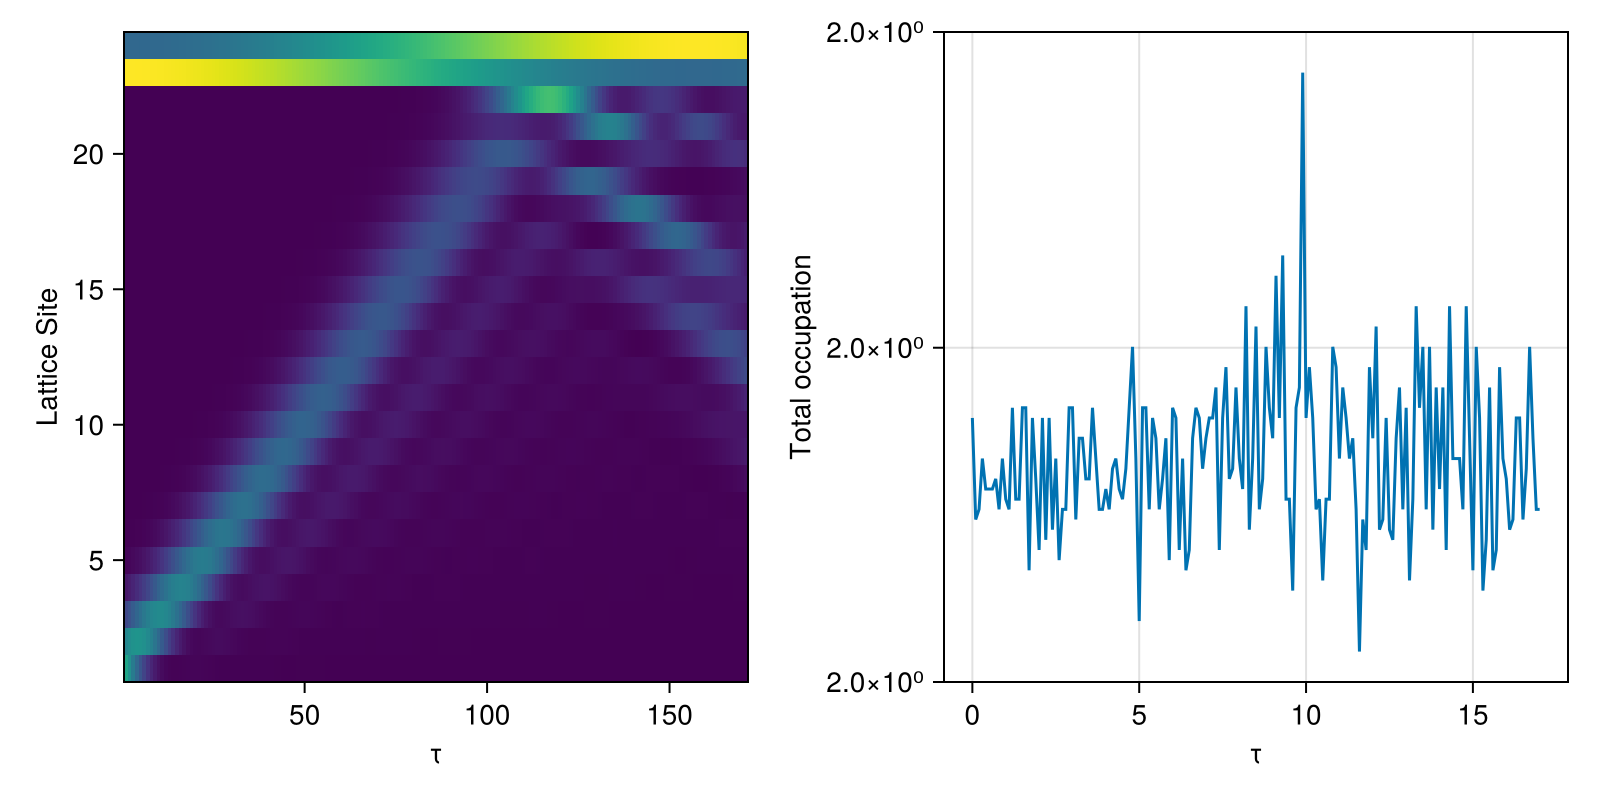

In [104]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Lattice Site")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Total occupation")

heatmap!(ax1, transpose(occupations_lin))
lines!(ax2, time_list, tot_occ)
f

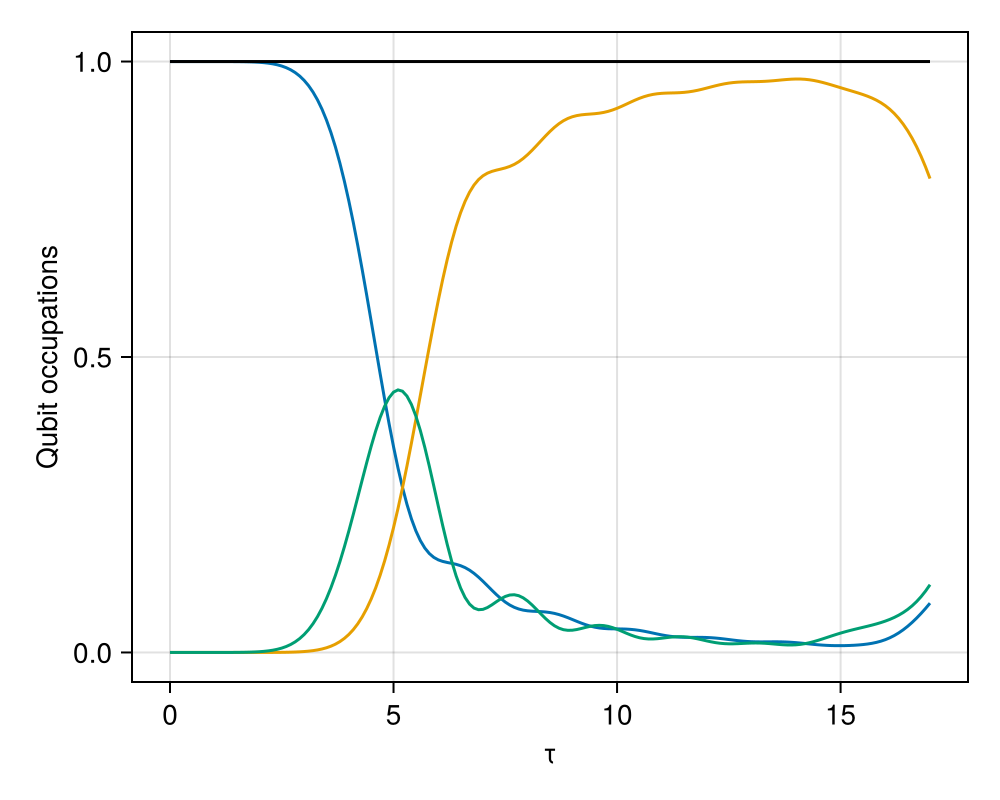

In [105]:
R_coeff = sum(occupations_lin[1:Bindex-2,:], dims=1)[1:end];
T_coeff = sum(occupations_lin[Bindex+1:end-2,:], dims=1)[1:end];
B_coeff = sum(occupations_lin[Bindex-1:Bindex,:], dims=1)[1:end];


f = Figure(size = (500, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Qubit occupations")

lines!(ax1,time_list, R_coeff)
lines!(ax1,time_list, T_coeff)
lines!(ax1,time_list, B_coeff)
lines!(ax1,time_list, R_coeff+ T_coeff+ B_coeff, color=:Black)
f


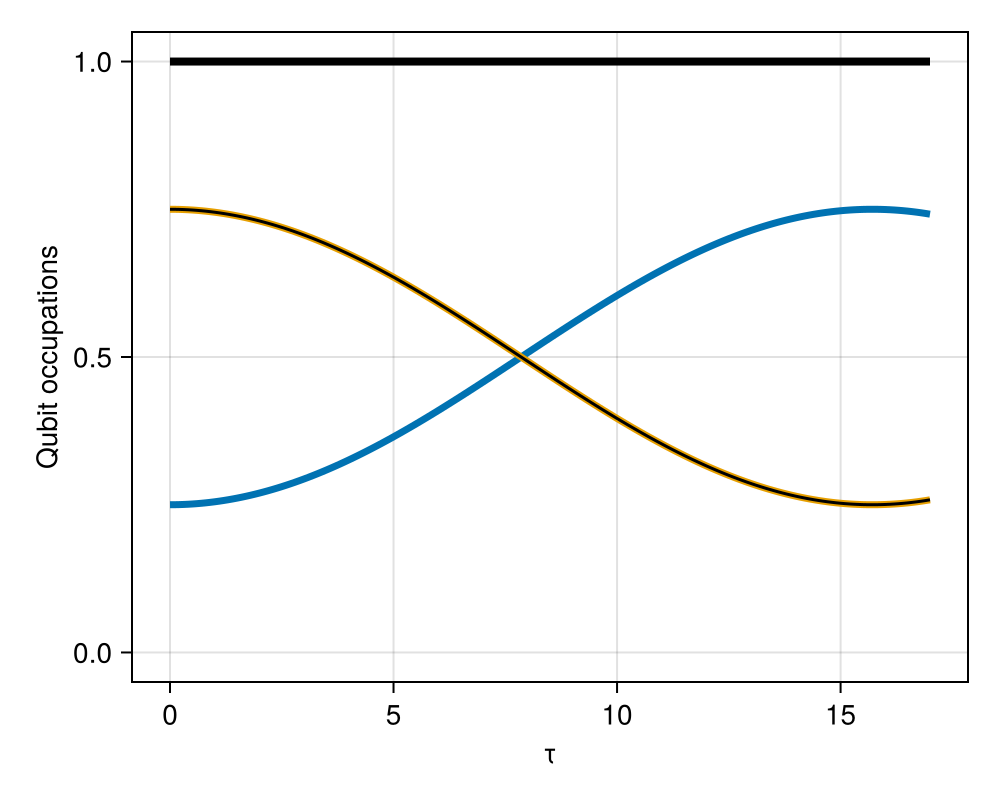

In [106]:
f = Figure(size = (500, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Qubit occupations")

lines!(ax1,time_list, occupations_lin[end,1:end], linewidth=3.5)
lines!(ax1,time_list, occupations_lin[end-1,1:end],linewidth=3.5)
lines!(ax1,time_list, occupations_lin[end,1:end] + occupations_lin[end-1,1:end], 
        color=:Black,linewidth=4)

ylims!(ax1, -0.05, 1.05)  # xmin, xmax, ymin, ymax

lines!(ax1,time_list, 0.75*cos.(time_list*t).^2 + 
                    0.25*sin.(time_list*t).^2 ,color=:Black)
ax1
f

## Bloch Sphere

In [107]:
psit = wave_functions[1]

ρ = outer(psit',psit)
ρTr = PartialTrace(ρ, L,  0)

s1, s2, s3, s4 = inds(ρTr)

# transform to the proper shape
row_comb = combiner(s2, s4,tags="row") # ket indices are rows
col_comb = combiner(s1, s3,tags="col") # bra indices are columns

# converto 4x4 matrix for the 2 qubit sites
ρtwo = ρTr * row_comb * col_comb 

ρmat = Array(ρtwo, combinedind(row_comb), combinedind(col_comb));

# Trim redundant deg of freedom cause SPINLESS fermions
real(ρmat)

4×4 Matrix{Float64}:
 0.0  0.0       0.0       0.0
 0.0  0.75      0.433013  0.0
 0.0  0.433013  0.25      0.0
 0.0  0.0       0.0       0.0

In [108]:
# TO get the correct placement check plev (prime level)
# primelevel(i) == 0 → ket index
# primelevel(i) > 0 → bra index

plev(s1), plev(s2), plev(s3),plev(s4)

(1, 0, 1, 0)

In [109]:
imag(ρmat[2:3,2:3])

2×2 Matrix{Float64}:
 6.245e-17    4.81986e-17
 4.81986e-17  2.68882e-17

In [110]:
cosθ_list = []
sinϕtlist = []

for i in 1:length(density_matrices[1,1,:])
    ρt = density_matrices[:,:,i]
    cosθt = 2*ρt[1,1] - 1
    θt = acos(cosθt)
    sinϕt = (ρt[2,1] - ρt[1,2])/(1im*sin(θt))
    
    push!(cosθ_list, cosθt)
    push!(sinϕtlist, sinϕt)
    
end

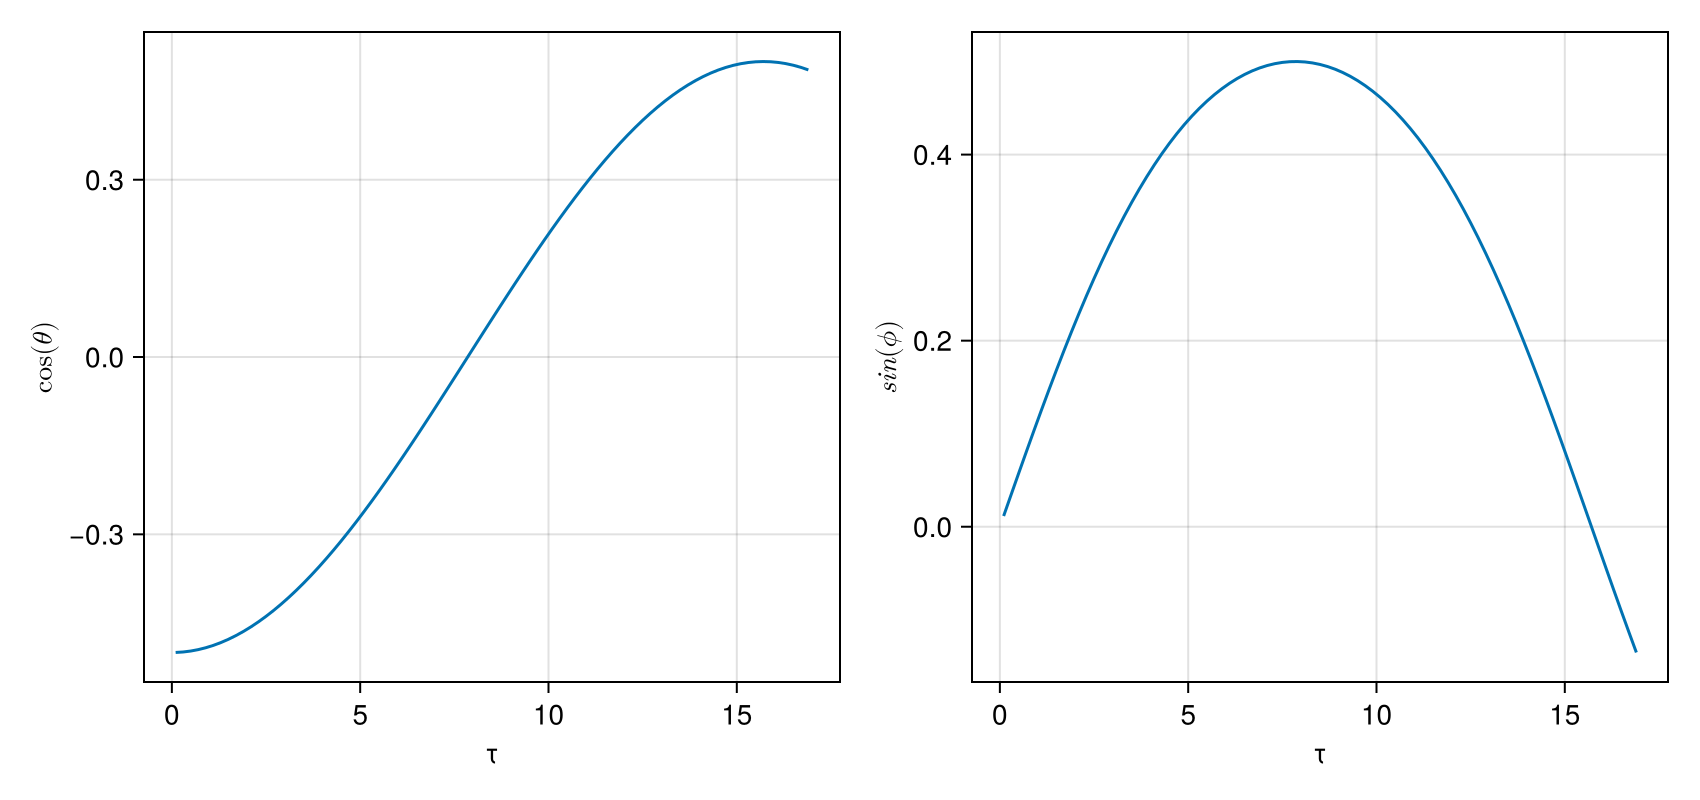

In [111]:
f = Figure(size = (850, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel=L"\cos(\theta)")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel=L"sin(\phi)")

lines!(ax1, time_list[2:2:end], real(cosθ_list))
lines!(ax2, time_list[2:2:end], real(sinϕtlist))

f

## Entropy

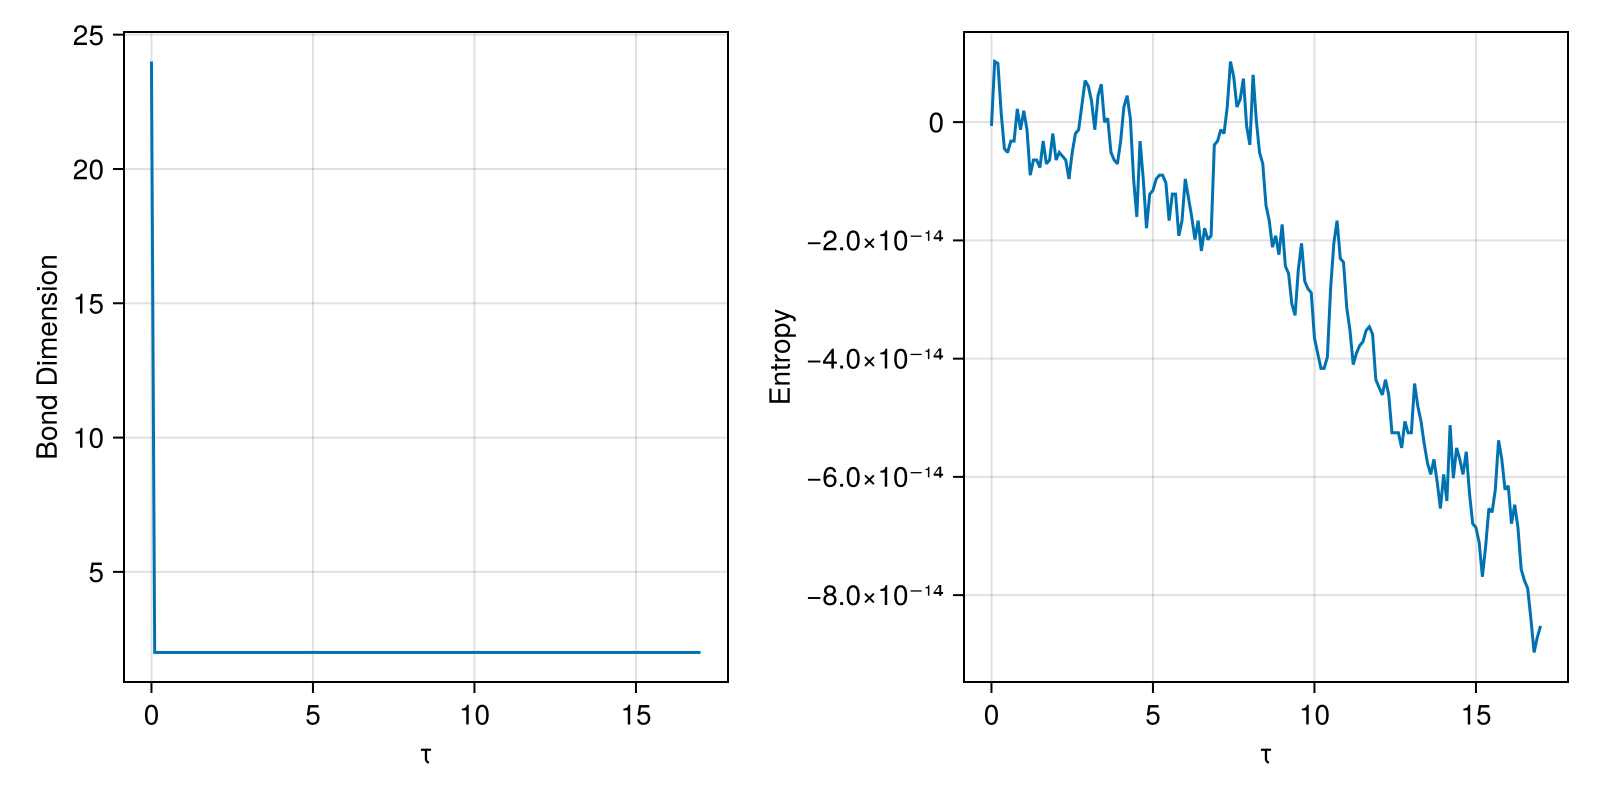

In [112]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Bond Dimension")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Entropy")

lines!(ax1, time_list, bond_dimensions)
lines!(ax2, time_list,entropies./log(2))

f
